<a href="https://colab.research.google.com/github/livadlivesey/Coursework/blob/main/NLE_1" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLE Assignment 1: Books vs DVDs

In this assignment, you will be investigating NLP methods for distinguishing reviews written about books from reviews written about DVDs.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [ ]:
candidateno=215865 #this MUST be updated to your candidate number so that you get a unique data sample


In [ ]:
#set up drives for resources.  Change the path as necessary

from google.colab import drive
#mount google drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/resources/')


Mounted at /content/drive/


In [ ]:
#do not change the code in this cell
#preliminary imports

#for setting up training and testing data
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
import random

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
from itertools import zip_longest


Sussex NLTK root directory is /content/drive/My Drive/Colab Notebooks/resources
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def feature_extract(review):
    """
    Generate a feature representation for a review
    :param review: AmazonReview object
    :return: dictionary of Boolean features
    """
    return {word:True for word in review.words()}

def get_training_test_data(categories=('book','dvd'),ratio=0.7,seed=candidateno):
    """
    Get training and test data for a given pair of categories and ratio, pre-formatted for use with NB classifier
    :param category: pair of categories of review corpus, two from ["kitchen, "dvd, "book", "electronics"]
    :param ratio: proportion of data to use as training data
    :return: pair of lists 
    """
    random.seed(candidateno)

    train_data=[]
    test_data=[]
    for category in categories:
      reader=AmazonReviewCorpusReader().category(category)    
      train, test = split_data(reader.documents(),ratio=ratio)
   
      train_data+=[(feature_extract(review),category)for review in train]
      test_data+=[(feature_extract(review),category)for review in test]
    random.shuffle(train_data)
    random.shuffle(test_data)

    return train_data,test_data

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [ ]:
#do not change the code in this cell
training_data,testing_data=get_training_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])
print(testing_data[0])

The amount of training data is 6526
The amount of testing data is 2799
The representation of a single data item is below
({'Clint': True, 'Eastwood': True, "'s": True, '``': True, 'The': True, 'Eiger': True, 'Sanction': True, 'was': True, 'made': True, 'in': True, '1975': True, 'and': True, ',': True, 'at': True, 'that': True, 'time': True, 'an': True, 'excellent': True, 'action': True, 'thriller': True, '.': True, 'Viewing': True, 'it': True, 'again': True, 'recently': True, 'I': True, 'surprised': True, 'how': True, 'well': True, 'has': True, 'held': True, 'up': True, 'This': True, 'is': True, 'due': True, 'mostly': True, 'to': True, 'the': True, 'location': True, 'shoots': True, '-': True, 'filmed': True, 'Monument': True, 'Valley': True, 'Swiss': True, 'Alps': True, 'instead': True, 'of': True, 'on': True, 'a': True, 'Hollywood': True, 'soundstage': True, 'These': True, 'guys': True, 'really': True, 'went': True, 'there': True, 'those': True, 'climbing': True, 'sequences': True, 'f

1) Use your training data to find
a) the top 20 words which occur more frequently in book reviews than in dvd reviews
b) the top 20 words which occur more frequently in dvd reviews than book reviews
Discuss what pre-processing techniques you have applied (or not applied) in answering this question, and why. [20%]

To pre-process the training data, I case normalised the words so that words with the same characters in the same sequence, will be counted as the same word for the word count. Lowering the case also allows the removal of stopwords which have capitalizations in the original data. 
I decided to remove the stopwords as this significantly reduces the size of the data, and allows for a more meaningful comparison between the words in the book and dvd data. 
I decided not to use stemming or lemmatization to save processing time.

In [ ]:
stop = set(stopwords.words('english'))
import collections
import math
from nltk.probability import FreqDist

def normalise(data):  
  normalised =[] #Create a list for the normalised training data

  for (dictionary,label) in data: #Iterate through the tuples in the training data
    lowered = {} #Create a dictionary for the lowered 
    for (k,v) in dictionary.items(): #Iterate though the key,value pairs in the dictionary
      if k.isalpha() and not k.lower() in stop: #If the key is alphabetic and not a stopword, add the lowered entry to lowered dictionary
       lowered[k.lower()] = v 

    normalised.append((lowered, label)) #Add each of the lowered entries to the list 'normalised'
  return normalised

normalised_train = normalise(training_data)



In [ ]:
def seperate_data(data):
  dvd = [] #Create a list for the dvd training data
  book = []#Create a list for the book training data
  for i in range(len(data)): #Iterate through the entries in the normalised and lowered data
    if data[i][1] == "book": #If the label for the entry is "book", add the words from the entry to the book data
      book += data[i][0].keys()
      
    if data[i][1] == "dvd":  #If the label for the entry is "dvd", add the words from the entry to the dvd data  
      dvd += data[i][0].keys()   
  return dvd, book

dvd_train, book_train = seperate_data(normalised_train) #Seperate the training data into lists for each of the categories


In [ ]:
def seperate_test_data(data):
  dvd = [] #Create a list for the dvd test data
  book = [] #Create a list for the book test data
  for i in range(len(data)): #Iterate through the test data
    if data[i][1] == "book": #If the label for an entry is "book", add the entry to the book testing data
      book.append(data[i])
    if data[i][1] == "dvd": #If the label for an entry is "dvd", add the entry to the dvd testing data
      dvd.append(data[i])
  return dvd, book



In [ ]:
def most_frequent_words(freq1, freq2, k):
  difference = [(w, f-freq2.get(w, 0)) for (w,f) in freq1.most_common()] #Create a list of tuples, where the first item is the word, and the second is the difference in frequency for that word
  sorteddiff = sorted(difference, key=lambda pair:pair[1], reverse=True) #Sort the list into descending order
  normalised=[w.lower() for (w,f) in sorteddiff] 
  filtered=[w for w in normalised if w.isalpha() and w not in stop] #Remove the number count for each word, check all words are alphabetic and do not include stopwords
  return filtered[:k] #Return the top 20 tuples in the list

dvdfreq = FreqDist(dvd_train) #Create a freq dist given the dvd data
bookfreq = FreqDist(book_train) #Create a freq dist given the book data


print(most_frequent_words(dvdfreq, bookfreq, 20))
print(most_frequent_words(bookfreq, dvdfreq, 20))

['movie', 'film', 'dvd', 'watch', 'one', 'see', 'like', 'great', 'movies', 'good', 'seen', 'watching', 'love', 'get', 'films', 'really', 'show', 'scenes', 'acting', 'best']
['book', 'read', 'books', 'reading', 'author', 'reader', 'written', 'writing', 'pages', 'information', 'novel', 'page', 'readers', 'chapter', 'authors', 'novels', 'research', 'chapters', 'ideas', 'published']


(a) The top 20 words which occur more frequently in book reviews than in dvd reviews are: book, read, books, reading, author, reader, written , writing, pages, information, novel, page, readers, chapter, authors, novels, research, chapters, ideas, published


(b) The top 20 words which occur more frequently in dvd reviews than in book reviews are: movie, film, dvd, watch, one, see, like, great, movies, good, seen, watching, love, get, films, really, show, scenes, acting, best

2) Design, build and test a word list classifier to classify reviews as being from the book domain or from the dvd domain.  Make sure you discuss 1) how you decide the lengths and contents of the word lists and ii) accuracy, precision and recall of your final classifier.[30%]

i) To decide the contents of the word lists, I used the most_frequent_words method, which finds the top 'k' more frequent words from each class, book or dvd. This means that words which may appear very frequently in both classes, but are not related to the class, are not used as identifiers for either class. I chose a word list length of 10 because this produced pretty reasonable scores for accuracy, precision, recall and F1 score, without a long running time. 

ii) The accuracy, precision, recall is shown by running the last cell of this question. The high numbers calculated by the confusion matrix, show a small proportion of false positives and false negatives when classifying a document into 'book' or 'dvd' categories, showing the word list classifier built is pretty effective. 

In [ ]:
from nltk.classify.api import ClassifierI
import random

class SimpleClassifier(ClassifierI): 

    def __init__(self, book, dvd): #The classifier is initialised with a list of words labelled 'book' and a list labelled 'dvd'
        self._book = book 
        self._dvd = dvd 

    def classify(self, review): #Classify method takes a review to be classified. A positive score indicates the review is about Books, a negative score indicates the review is about DVDs
        score = 0 
        
        for word in review.keys(): #Iterate through the list of words given 
          if word in self._book: 
            score+=1 #If the current word in the list to be classified is found in the list of labelled 'book data', add one. 
          if word in self._dvd: 
            score-=1 #If the current word in the list to be classified is found in the list of labelled 'dvd' data, subtract one
        
        if score < 0: return "dvd" 
        if score > 0: return "book"
        if score == 0: return (random.choice(["dvd", "book"])) #If the score is 0, either label is selected randomly

    def batch_classify(self, reviews): 
        return [self.classify(review.words() if hasattr(review, 'words') else review) for review in reviews]

    def labels(self): 
        return ("book", "dvd")


class SimpleClassifier2(SimpleClassifier): #Another class of classifier which inherits from the previous classifier, but takes an additional parameter k, which defines the length of the word list to classify

    def __init__(self, k):
        self._k=k

    def train(self, book_training, dvd_training):
        book_freqdist=FreqDist(book_training) #Create a frequency distribution for the training data labelled book
        dvd_freqdist=FreqDist(dvd_training) #Create a frequency distribution for the training data labelled dvd
        self._book=most_frequent_words(book_freqdist, dvd_freqdist, self._k) #Assign the top k most frequent words from book over dvd to the book word list
        self._dvd=most_frequent_words(dvd_freqdist, book_freqdist, self._k) #Assign the top k most frequent words from dvd over book to the dvd word list
      
      




In [ ]:
def classifier_evaluate(classifier,test_data):
    
    docs,goldstandard=zip(*test_data) #Convert the list of pairs of words and labels, into a pair of lists, where the index of each list corresponds to the index in the other
    predictions=classifier.batch_classify(docs) #Batch classify all the documents
    #print(predictions)
    correct=0
    for (prediction,gold) in zip(predictions,goldstandard): #Iterate through the lists, checking if the prediction matches the given label (goldstandard)
        if prediction ==gold:
            correct+=1 #Add 1 for each accurate prediction
    return correct/len(test_data) #Find the proportion of accurate predictions

class ConfusionMatrix:
  def __init__(self, predictions, goldstandard, classes=("dvd","book")):

    (self.c1,self.c2)=classes
    self.TP=0
    self.FP=0
    self.FN=0
    self.TN=0
    for (prediction,gold) in zip(predictions,goldstandard):
        if gold==self.c1:
            if prediction==self.c1:
                self.TP+=1
            else:
                self.FN+=1
        
        elif prediction==self.c1:
            self.FP+=1
        else:
            self.TN+=1
        
    
  def precision(self):
    
    p = self.TP / (self.TP + self.FP)
    
    return p
  
  def recall(self):
    r= self.TP / (self.TP + self.FN)
    
    return r
  
  def f1(self):
    f1= 2 * (precision * recall ) / (precision + recall )
      
    return f1 



In [ ]:
normalised_test = normalise(testing_data)
dvd_test, book_test = seperate_test_data(normalised_test)
test_data=dvd_test+book_test


test_classifier = SimpleClassifier2(10)
test_classifier.train(book_train, dvd_train)
accuracy = classifier_evaluate(test_classifier, test_data)
#print(accuracy)

docs,labels = zip(*testing_data)
sent_cm=ConfusionMatrix(test_classifier.batch_classify(docs), labels)
precision = sent_cm.precision()
recall = sent_cm.recall()
f1score = sent_cm.f1()

#print(precision)
#print(recall)
#print(f1score)

import pandas as pd

data = {'Accuracy':  [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1score],   
        }

df = pd.DataFrame (data, columns = ['Accuracy','Precision','Recall', 'F1 Score'], index = ['Word List Classifier'])

print (df)


                      Accuracy  Precision    Recall  F1 Score
Word List Classifier   0.85602   0.831956  0.916262  0.872076


3) Compare the performance of your word list classifier with a Naive Bayes classifier (e.g., from NLTK).  Make sure you discuss the results. [20%]

For the Naive Bayes classifier, I used the one developed in the labs as I was more familiar with it. Unsurprisingly, the NB classifier had higher precision, recall, accuracy, and F1 score compared to a simple word list classifier. This is because it uses probability to decide whether a certain document is in either the 'book' or 'dvd' category, rather than using words that have been seen before to classify.
However, despite NB Classifier showing higher scores in all 4 measures of performance, it is important to note that the word list classifier is still pretty effective, achieving higher than 0.8 for accuracy, precision, recall and f1. This means that out of the predictions made by the classifier, a high proportion are correct (true positives or true negatives)

In [ ]:
class NBClassifier:
    
    def __init__(self):
        
        pass
    
    def _set_known_vocabulary(self,training_data):
        
        known=[]
        for doc,label in training_data:
            known+=list(doc.keys())
        self.known= set(known)
    
    def _set_priors(self,training_data):
        
        priors={}
        for (doc,label) in training_data:
            priors[label]=priors.get(label,0)+1
        total=sum(priors.values())
        for key,value in priors.items():
            priors[key]=value/total
        self.priors=priors
        
    def _set_cond_probs(self,training_data):       
        conds={}
        for(doc,label) in training_data:
            classcond=conds.get(label,{})
            for word in doc.keys():
                classcond[word]=classcond.get(word,0)+1
        
            conds[label]=classcond
    
        for label, classcond in conds.items():
            for word in self.known:
        
                classcond[word]=classcond.get(word,0)+1
            conds[label]=classcond
            
        for label,dist in conds.items():
            total=sum(dist.values())
            conds[label]={key:value/total for (key,value) in dist.items()}
        
        self.conds=conds
    
    def train(self,training_data):
        self._set_known_vocabulary(training_data)
        self._set_priors(training_data)
        self._set_cond_probs(training_data)
    
    def classify(self,doc):
        
        doc_probs={key:math.log(value) for (key,value) in self.priors.items()}
        for word in doc.keys():
            if word in self.known:
                doc_probs={classlabel:sofar+math.log(self.conds[classlabel].get(word,0)) for (classlabel,sofar) in doc_probs.items()}

        highprob=max(doc_probs.values())
        classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
        return random.choice(classes)
    
    def batch_classify(self,docs):
        return [self.classify(doc) for doc in docs]
 

In [ ]:
nb_classifier = NBClassifier()
nb_classifier.train(training_data)
nb_accuracy = classifier_evaluate(nb_classifier, testing_data)

nb_cm = ConfusionMatrix(nb_classifier.batch_classify(docs), labels)
nb_precision = nb_cm.precision()
nb_recall = nb_cm.recall()
nb_f1score = 2 * (nb_precision * nb_recall) / (nb_precision + nb_recall) 






In [ ]:
data = {'Accuracy':  [accuracy, nb_accuracy],
        'Precision': [precision, nb_precision],
        'Recall': [recall, nb_recall],
        'F1 Score': [f1score, nb_f1score],   
        }

df = pd.DataFrame (data, columns = ['Accuracy','Precision','Recall', 'F1 Score'], index = ['Word List Classifier', 'Naive Bayes Classifier'])

print (df)

                        Accuracy  Precision    Recall  F1 Score
Word List Classifier    0.856020   0.831956  0.916262  0.872076
Naive Bayes Classifier  0.929618   0.919122  0.965413  0.941699


4) Design and carry out an experiment into the impact of the amount of training data on each of these classifiers.  Make sure you describe design decisions in your experiment, include a graph of your results and discuss your conclusions. [30%] 

First we need a word list classifier which takes data in the same format as the Naive Bayes classifier so that we can easily compare them. Then, using a range of sample sizes for the training data and generating a new sample for each time, we can calculate the accuracy, precision and recall for the two classifiers, NB and Word List, and find an average of these scores. 

When doing this last question, I have noticed that suddenly the scores for the word list classifier are drastically lower than in other questions. I have tried to find the source of this error but have not been able to. Therefore I have tried to show that I understand the intent of this question, how to calculate, compare and display the results of the precision, recall and accuracy in a suitable way. 

From the results I do have, the precision and accuracy of the Naive Bayes classifier very quickly increases with the amount of training data, whereas the Word List classifier doesnt show much increase with the training data. I think this is because where the WLC has more words, more of these are likely to be used in other categories of reviews, whereas NB uses the higher training sample to find the probabilities of words being in a certain category, and hence is more likely to correctly predict the class of a document. 

In [ ]:
from functools import reduce
class WordListClassifier(SimpleClassifier):
    #this WordListClassifier uses the same feature representation as the NB classifier
    #i.e., a multivariate Bernouilli event model where multiple occurrences of the same word in the same document are not counted.
        
    def __init__(self,k):
        self._labels=["book","dvd"]
        self.k=k
        
    def get_all_words(self,docs):
        return reduce(lambda words,doc: words + list(doc.keys()), docs, [])
    
    def train(self,training_data):
        book_train=[doc for (doc,label) in normalise(training_data) if label == self.labels()[0]]
        dvd_train=[doc for (doc,label) in normalise(training_data) if label == self.labels()[1]]
        
        book_freqdist=FreqDist(self.get_all_words(book_train))
        dvd_freqdist=FreqDist(self.get_all_words(dvd_train))
        
        self._book=most_frequent_words(book_freqdist, dvd_freqdist, self.k)
        self._dvd=most_frequent_words(book_freqdist, dvd_freqdist, self.k)

The accuracy of Word List classifier is 0.49446230796713114
The accuracy of Naive Bayes classifier is 0.9296177206145052
The accuracy of Word List classifier is 0.49446230796713114
The accuracy of Naive Bayes classifier is 0.9296177206145052


,0,1
0,Word List,0.494462
1,Naive Bayes,0.929618


(0.0, 1.0)

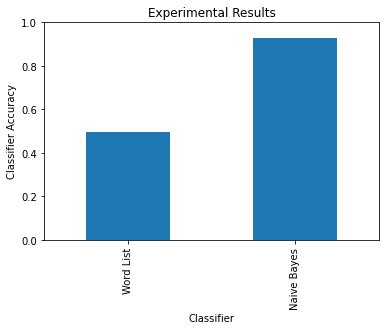

In [ ]:
word_list_size = 50
classifiers={"Word List":WordListClassifier(word_list_size),
             "Naive Bayes":NBClassifier()}
use=["Word List","Naive Bayes"]
number_of_runs=3

results={}
for key in classifiers.keys():
  results[key]=0

for i in range(number_of_runs):
  training,testing=get_training_test_data()

  for name,classifier in classifiers.items():
    if name in use:
      classifier.train(training)
      accuracy=classifier_evaluate(classifier,testing)
      print("The accuracy of {} classifier is {}".format(name,accuracy))
      results[name]=results[name]+(accuracy/number_of_runs)

    

df = pd.DataFrame(list(results.items()))
display(df)
ax = df.plot.bar(title="Experimental Results",legend=False,x=0)
ax.set_ylabel("Classifier Accuracy")
ax.set_xlabel("Classifier")
ax.set_ylim(0,1.0)

The precision of Word List classifier is 0.5847578347578347
The precision of Naive Bayes classifier is 0.9191218948584633
The precision of Word List classifier is 0.5847578347578347
The precision of Naive Bayes classifier is 0.9191218948584633
The precision of Word List classifier is 0.5847578347578347
The precision of Naive Bayes classifier is 0.9191218948584633


,0,1
0,Word List,0.584758
1,Naive Bayes,0.919122


(0.0, 1.0)

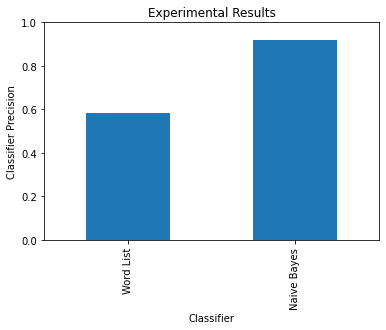

In [ ]:
word_list_size = 100
classifiers={"Word List":WordListClassifier(word_list_size),
             "Naive Bayes":NBClassifier()}
use=["Word List","Naive Bayes"]
number_of_runs=3

results={} #Empty list for the results
for key in classifiers.keys(): 
  results[key]=0

for i in range(number_of_runs): 
  training,testing=get_training_test_data() #For each run, create a new sample of data

  for name,classifier in classifiers.items(): #Iterate through the classifier items
    if name in use:
      classifier.train(training) #Train each classifier
      senti_cm=ConfusionMatrix(classifier.batch_classify(docs),labels) #Create a confusion matrix for the current classifier
      print("The precision of {} classifier is {}".format(name,senti_cm.precision())) #Calculate the precision of the classifier
      results[name]=results[name]+(senti_cm.precision()/number_of_runs) #Add the result to the list of results

    

df = pd.DataFrame(list(results.items())) #Display the results
display(df)
ax = df.plot.bar(title="Experimental Results",legend=False,x=0)
ax.set_ylabel("Classifier Precision")
ax.set_xlabel("Classifier")
ax.set_ylim(0,1.0)

In [ ]:
from random import sample
word_list_size = 100
classifiers={"Word List":WordListClassifier(word_list_size),
             "Naive Bayes":NBClassifier()}
use=["Word List","Naive Bayes"]
sample_sizes=[1,50,500]
number_of_runs=2

results=[]


for size in sample_sizes: #Use different sample sizes to evaluate the classifiers, for each of these sample sizes
  for i in range(number_of_runs): #For runs
    training,testing=get_training_test_data() #Get a new sample
    training_sample=sample(training,size) #Randomise the sample
    res=[]
    for name,classifier in classifiers.items(): #For each classifier
      
      if name in use: #If the name in the classifier list
        classifier.train(training_sample) #Train classifier
        accuracy=classifier_evaluate(classifier,testing) #Evaluate the accuracy
        print("The accuracy of {} classifier with training sample size {} is {}".format(name,size, accuracy))
        res.append(accuracy) #Add the accuracy to list of results
    results.append([size]+res) #Add the result along with the sample size for each results to final results

    
results

The accuracy of Word List classifier with training sample size 1 is 0.4841014648088603
The accuracy of Naive Bayes classifier with training sample size 1 is 0.41121829224723117
The accuracy of Word List classifier with training sample size 1 is 0.4841014648088603
The accuracy of Naive Bayes classifier with training sample size 1 is 0.41121829224723117
The accuracy of Word List classifier with training sample size 50 is 0.49231868524473027
The accuracy of Naive Bayes classifier with training sample size 50 is 0.6780993211861379
The accuracy of Word List classifier with training sample size 50 is 0.49231868524473027
The accuracy of Naive Bayes classifier with training sample size 50 is 0.6780993211861379
The accuracy of Word List classifier with training sample size 500 is 0.4976777420507324
The accuracy of Naive Bayes classifier with training sample size 500 is 0.872454448017149
The accuracy of Word List classifier with training sample size 500 is 0.4976777420507324
The accuracy of Naiv

[[1, 0.4841014648088603, 0.41121829224723117],
 [1, 0.4841014648088603, 0.41121829224723117],
 [50, 0.49231868524473027, 0.6780993211861379],
 [50, 0.49231868524473027, 0.6780993211861379],
 [500, 0.4976777420507324, 0.872454448017149],
 [500, 0.4976777420507324, 0.872454448017149]]

,sample size,word list accuracy,NB accuracy
0,1,0.484101,0.411218
1,1,0.484101,0.411218
2,50,0.492319,0.678099
3,50,0.492319,0.678099
4,500,0.497678,0.872454
5,500,0.497678,0.872454


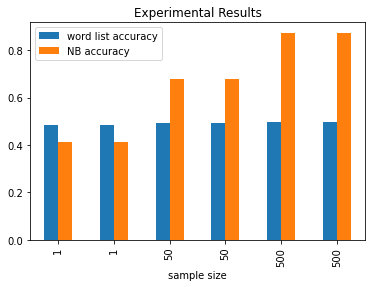

In [ ]:
df = pd.DataFrame(results,columns=["Sample Size","Word List Accuracy","NB Accuracy"])
display(df)
ax = df.plot(kind="bar",title="Experimental Results",x="sample size")

In [ ]:
sample_sizes=[1,50,500]
number_of_runs=2

results2=[]


for size in sample_sizes: #Use different sample sizes to evaluate the classifiers, for each of these sample sizes
  for i in range(number_of_runs): #For runs
    training,testing=get_training_test_data() #Get a new sample
    training_sample=sample(training,size) #Randomise the sample
    res2=[]
    for name,classifier in classifiers.items(): #For each classifier
      
      if name in use: #If the name in the classifier list
        classifier.train(training_sample) #Train classifier
        senti_cm=ConfusionMatrix(classifier.batch_classify(docs),labels) #Create a confusion matrix for the current classifier
        precision2 = senti_cm.precision()
        print("The precision of {} classifier is {}".format(name,precision2)) #Calculate the precision of the classifier
        res2.append(precision2) #Add the prescision to list of results
    results2.append([size]+res2) #Add the result along with the sample size for each results to final results

    
results2

The precision of Word List classifier is 0.5739130434782609


ZeroDivisionError: ignored

In [ ]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 388

import io
from nbformat import current

filepath="/content/drive/My Drive/Colab Notebooks/NLEassignment1.ipynb"
question_count=388

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))